# Project: Identify Customer Segments

By creating customer segmentation and comparing to general population, one can know which part of the general population are more likely to be customer and which part are not. I analyzed demographics data for customers of a mail-order sales company in Germany, comparing it to demographics information for the general population.

Here I used different approaches to pre-process the data, and then I used unsupervised learning techniques, PCA (Principle Componets Analysis) and k-NN (k-nearest neighbor algorithm), to perform customer segmentation and to identify the core customer traits of the company. 

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `zadias.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 366 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `DIAS_Attributes_Values_2017.xlsx`: Summary of feature attributes for demographics data; 351 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information will be used to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.



In [97]:
# Load in the general demographics data.
azdias = pd.read_csv('zadias.csv', delimiter=',')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')


In [88]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [74]:
# Check the structure of the data 
no_unamed = lambda x: 'Unnamed' not in x
attributes_values = pd.read_excel('DIAS_Attributes_Values_2017.xlsx', header=1, usecols=no_unamed)
attributes_info = pd.read_excel('DIAS_Information_Levels_Attributes.xlsx', header=1, usecols=no_unamed)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [92]:
attributes_values.head()


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [76]:
attributes_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [4]:
print('The dataset has',len(azdias) ,'rows')
print('The dataset has',len(azdias.columns) ,'columns')

The dataset has 891221 rows
The dataset has 366 columns


In [77]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [78]:
attributes_values.dropna()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [90]:
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [93]:
common_to_all = (set(attributes_list) & set(azdias_list) )
unique_to_azdias = (set(azdias_list) - set(attributes_list) )

unique_to_attributes = (set(attributes_list)  - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of columns common to 2 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))

print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to 2 daframes:  272
No of columns specific to azdias: 94
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42
No of columns exclusive to azdias vs attributes: 42


We have 42 unique columns given in the attribute-values data which are not present in azdias or customer data. This might be due to errors in recording these columns. We can go further correcting these mistakes and analysing what is the reason behing these missing columns. But for this analysis we are going to neglect this information and consider only the 272 columns which are common to all three dataframes to replace the 'unkown' values.

In [95]:
feat_info = attributes_values

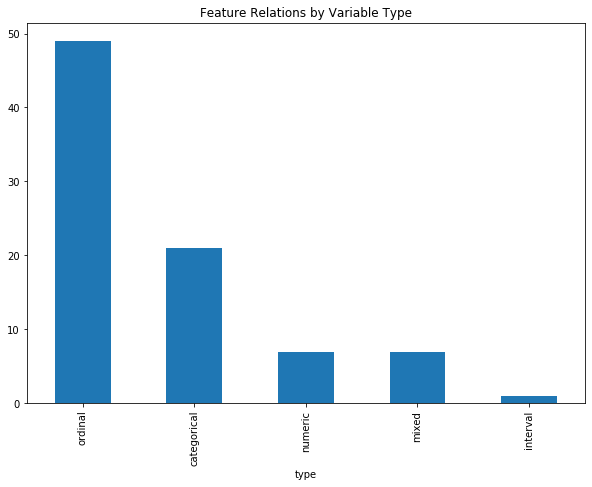

In [98]:
(feat_info.groupby('type').count()['attribute']
                        .sort_values(ascending = False).plot(kind = 'bar', figsize = (10, 7)))
plt.title('Feature Relations by Variable Type')
plt.show()

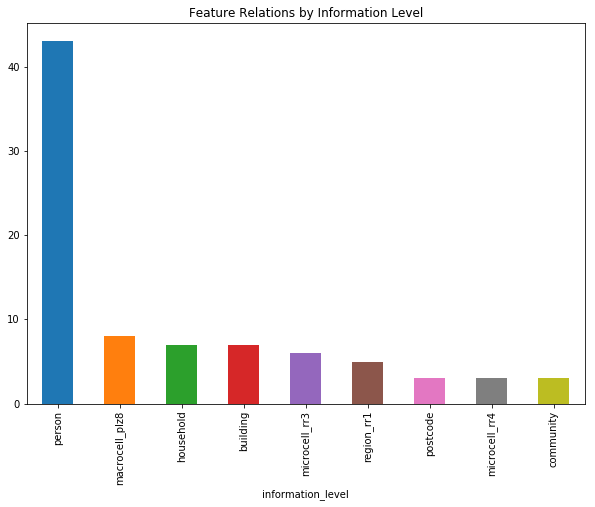

In [6]:
(feat_info.groupby('information_level').count()['type']
                        .sort_values(ascending = False).plot(kind = 'bar', figsize = (10, 7)))
plt.title('Feature Relations by Information Level')
plt.show()


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column.This file could help make cleaning decisions during this stage of the project. First of all, I assess the demographics data to deal with missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. To clean the data, I first Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. I also evaluated how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


There are 5 different types of missing data encodings. These types will be analyzed separately

In [42]:
feat_info['missing_or_unknown'].replace({'[-1,X]': '[-1,"X"]',
                                         '[-1,XX]': '[-1,"XX"]',
                                          '[XX]': '["XX"]'}, inplace = True)
encodings = feat_info.set_index('attribute')['missing_or_unknown'].to_dict()
encodings = {key: {k: np.nan for k in literal_eval(value)} for key, value in encodings.items()}


In [43]:
encodings

{'AGER_TYP': {-1: nan, 0: nan},
 'ALTERSKATEGORIE_GROB': {-1: nan, 0: nan, 9: nan},
 'ANREDE_KZ': {-1: nan, 0: nan},
 'CJT_GESAMTTYP': {0: nan},
 'FINANZ_MINIMALIST': {-1: nan},
 'FINANZ_SPARER': {-1: nan},
 'FINANZ_VORSORGER': {-1: nan},
 'FINANZ_ANLEGER': {-1: nan},
 'FINANZ_UNAUFFAELLIGER': {-1: nan},
 'FINANZ_HAUSBAUER': {-1: nan},
 'FINANZTYP': {-1: nan},
 'GEBURTSJAHR': {0: nan},
 'GFK_URLAUBERTYP': {},
 'GREEN_AVANTGARDE': {},
 'HEALTH_TYP': {-1: nan, 0: nan},
 'LP_LEBENSPHASE_FEIN': {0: nan},
 'LP_LEBENSPHASE_GROB': {0: nan},
 'LP_FAMILIE_FEIN': {0: nan},
 'LP_FAMILIE_GROB': {0: nan},
 'LP_STATUS_FEIN': {0: nan},
 'LP_STATUS_GROB': {0: nan},
 'NATIONALITAET_KZ': {-1: nan, 0: nan},
 'PRAEGENDE_JUGENDJAHRE': {-1: nan, 0: nan},
 'RETOURTYP_BK_S': {0: nan},
 'SEMIO_SOZ': {-1: nan, 9: nan},
 'SEMIO_FAM': {-1: nan, 9: nan},
 'SEMIO_REL': {-1: nan, 9: nan},
 'SEMIO_MAT': {-1: nan, 9: nan},
 'SEMIO_VERT': {-1: nan, 9: nan},
 'SEMIO_LUST': {-1: nan, 9: nan},
 'SEMIO_ERL': {-1: nan, 9: n

In [44]:
for column,mapping in encodings.items():
    azdias[column].replace(mapping, inplace = True)

In [15]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. Here I used matplotlib's function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I just remove them from the dataframe.

In [16]:
# Perform an assessment of how much missing data there is in each column of the dataset.

def extract_columns_with_nan(df):

    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]

    # Calculate percentage of NaN for each column
    dic_nan = {'sum': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}

    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)

    # Sort by percentage
    df_nan.sort_values(by='percent', ascending=False, inplace=True)

    return df_nan

In [17]:
azdias_nan = extract_columns_with_nan(azdias)


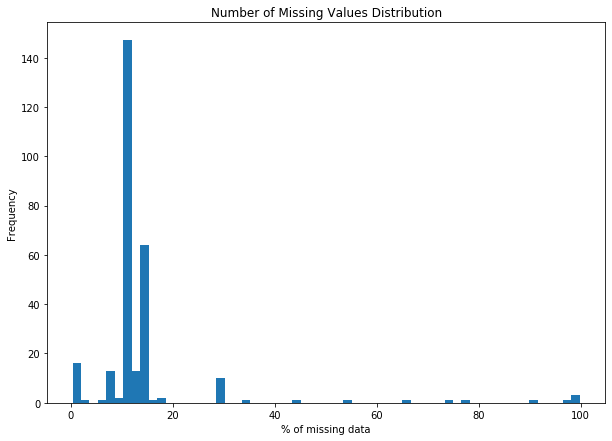

In [21]:
#Investigate patterns in the amount of missing data in each column.

azdias_nan['percent'].plot(kind = 'hist', figsize = (10, 7), bins = 60,
                                            title = 'Number of Missing Values Distribution')

plt.xlabel('% of missing data')   ;

It seemed that the missing ratio of most attributes are below 30%. Therefore, I will delete the outliers based on the criterion.

In [45]:
# Delete the outlier attributes that have more than 30% missing data ratio
attributes_outlier_list = azdias_nan[azdias_nan['percent'] >= 0.3].index.to_list()
azdias_cleaned = azdias.drop(attributes_outlier_list, axis=1)

In [46]:
azdias_cleaned

,LNR,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,...,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ
0,910215,0,0,10,0,0,0,10,10,0,...,5,5,5,4,7,2,3,1,3,1
1,910220,0,0,10,0,0,0,10,10,0,...,2,3,7,6,4,5,6,1,5,2
2,910225,0,0,10,0,0,0,10,10,0,...,4,3,3,4,3,4,3,4,5,2
3,910226,0,0,10,0,0,0,10,10,0,...,4,1,4,3,2,5,4,4,3,2
4,910241,3,5,5,1,2,0,10,5,6,...,4,2,4,2,4,6,2,7,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,0,0,10,0,0,0,10,10,0,...,1,3,4,4,3,2,2,2,4,2
891217,825771,0,0,10,0,0,0,10,10,0,...,7,5,6,4,7,4,2,4,6,1
891218,825772,0,0,9,6,0,0,10,9,0,...,3,3,6,7,5,5,7,2,4,2
891219,825776,0,0,10,0,0,0,10,10,0,...,3,5,7,5,7,7,5,6,5,1


In [47]:
feat_info[feat_info['attribute'].isin(attributes_outlier_list)]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
3,CJT_GESAMTTYP,person,categorical,[0]
11,GEBURTSJAHR,person,numeric,[0]
12,GFK_URLAUBERTYP,person,categorical,[]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


The rest of the outlier columns will be treated as categorical features and transformed using one-hot encoding

#### Step 1.1.3: Assess Missing Data in Each Row

A similar assessment for the rows of the dataset. How much data is missing in each row? Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special.

Text(0.5, 0, 'Number of Missing Values')

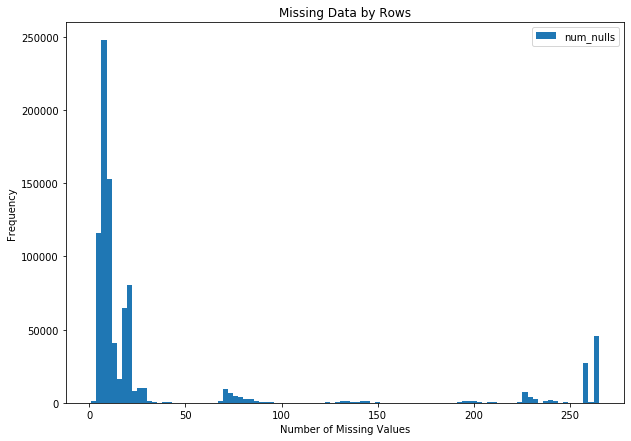

In [22]:
azdias_nullcnt_row = pd.DataFrame(azdias.isnull().sum(axis = 1))
azdias_nullcnt_row.columns = ['num_nulls']
azdias_nullcnt_row.plot(kind = 'hist', bins = 100, figsize = (10, 7), title ='Missing Data by Rows')
plt.xlabel('Number of Missing Values')

There are several rows that has more than 30 missing values across the column. Now build function that separates the data into two parts, and visualize the distributions separately

In [26]:
def visualizeDistAzdias(azdias_nullcnt_row, column, threshold = 30):
    # separate dataset based on number of null values in rows 
    lessNull_rows = list(azdias_nullcnt_row[azdias_nullcnt_row['num_nulls']  < threshold].index)
    moreNull_rows = list(azdias_nullcnt_row[azdias_nullcnt_row['num_nulls']  > threshold].index)
    # Flag the high missing value rows
    azdias_moreNull = azdias.loc[moreNull_rows, :] 
    azdias_lessNull = azdias.loc[lessNull_rows, :] 
    # create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (20, 7))
    ax1.set_title('Less Missing Values')
    ax2.set_title('More Missing Values')
    sns.barplot(x = column, y = column, ax = ax1,
            data = azdias_lessNull, estimator= lambda x: len(x)/len(azdias_lessNull)* 100)
    sns.barplot(x = column, y = column, ax = ax2, 
            data = azdias_moreNull, estimator= lambda x: len(x)/len(azdias_moreNull)* 100)
    plt.ylabel('% values among total')
    plt.suptitle(column)

Now visualize 5 different columns

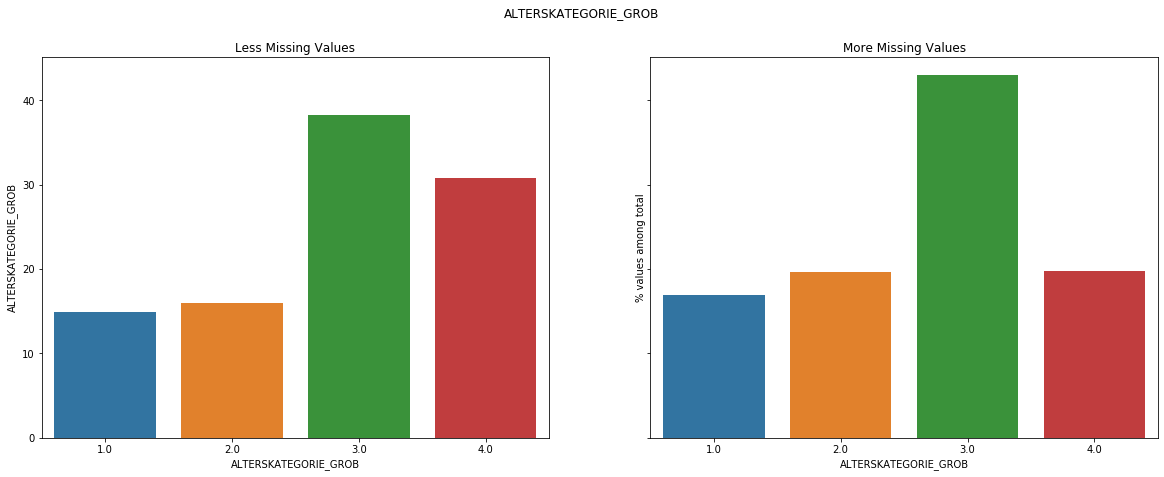

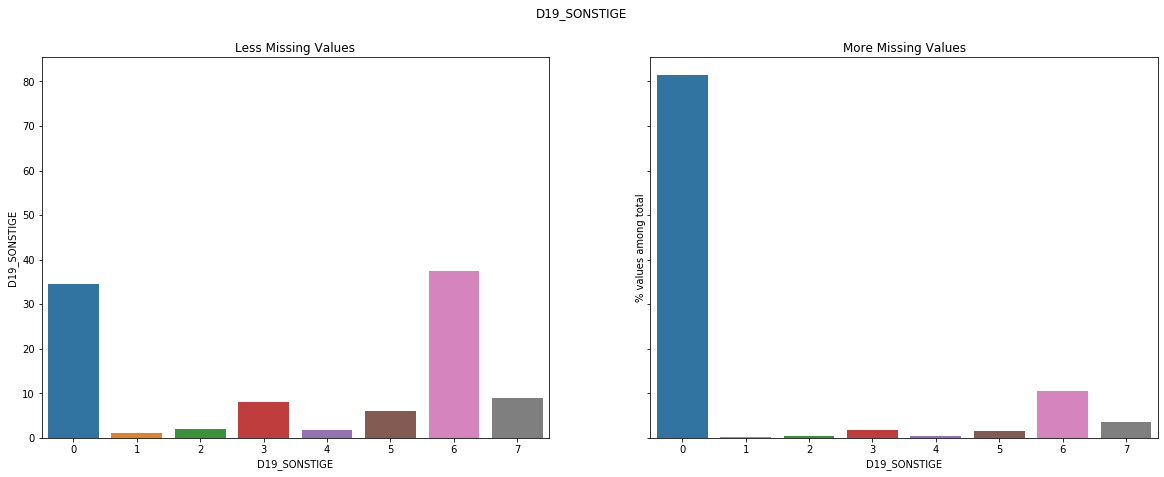

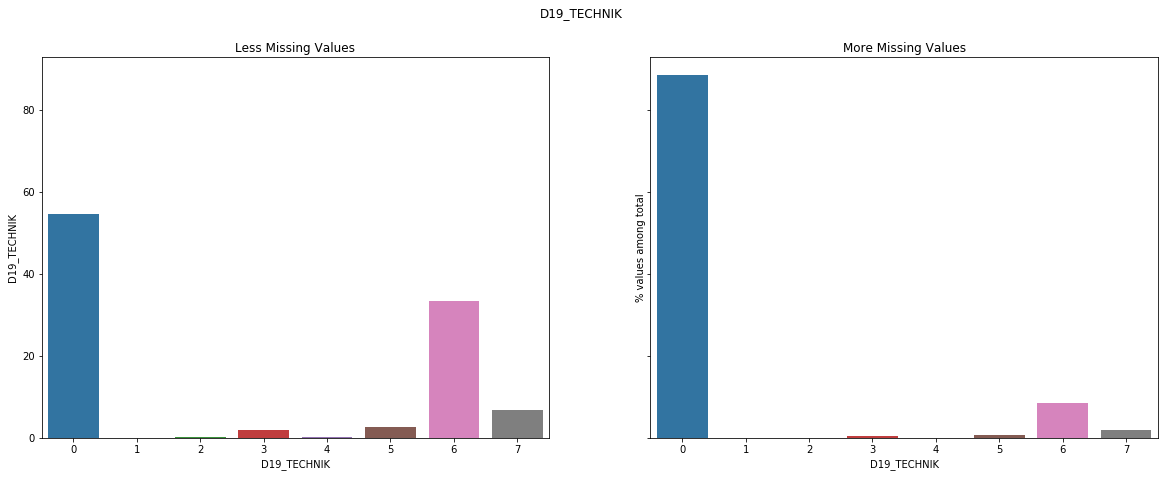

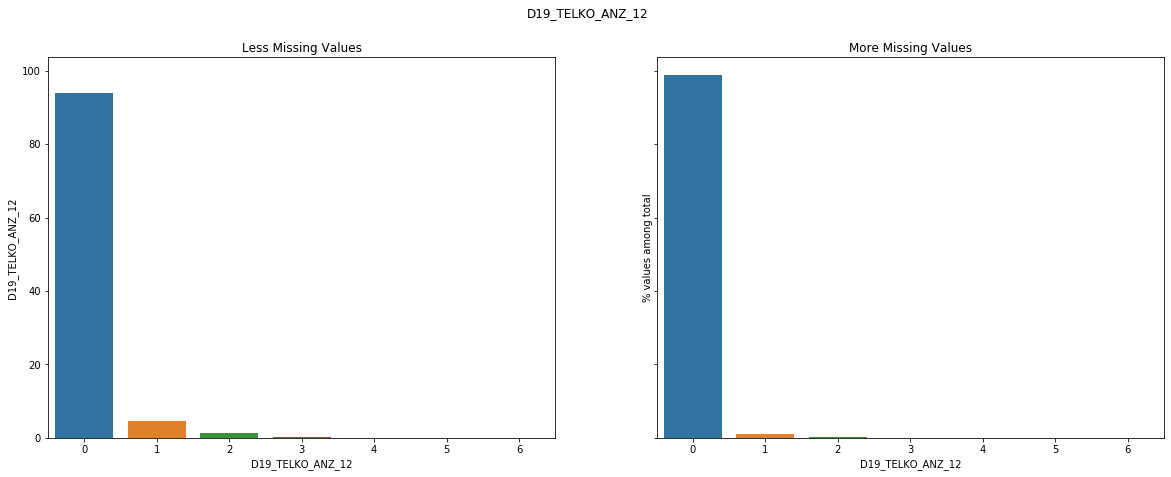

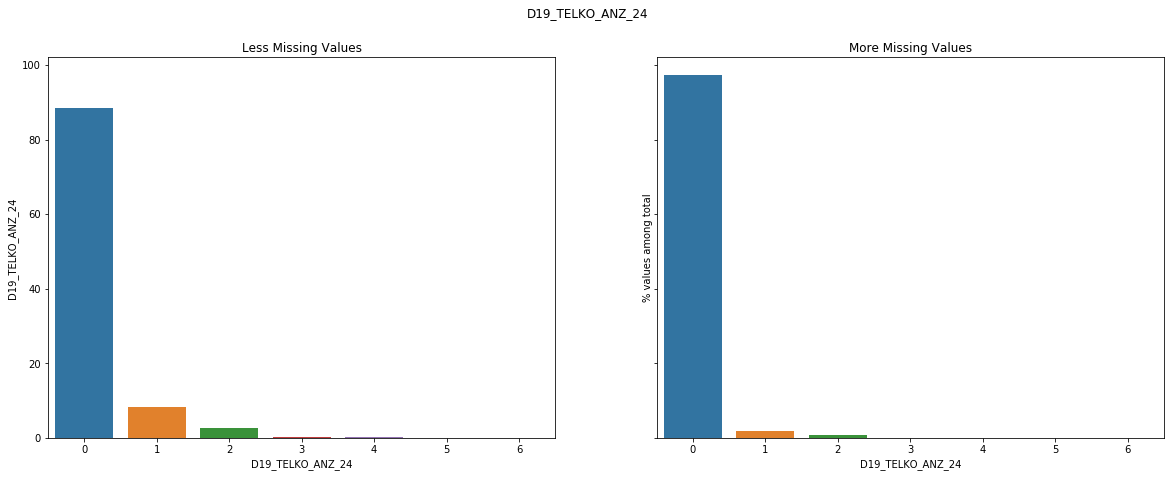

In [29]:
for i in ['ALTERSKATEGORIE_GROB', 'D19_SONSTIGE','D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24']:
    visualizeDistAzdias(azdias_nullcnt_row, i, 10)

#### Discussion 1.1.3: Assess Missing Data in Each Row



Based on the graph above, the distribution of the deleted rows are not different from the rows left, so I will drop all the rows that have more than 30 missing value. From the histogram of missing value distributions, the rows with more than 30 missing values will be dropped, while the rest of the missing values will be imputed.

In [48]:
azdias_nan_counts = len(azdias_cleaned.columns) - azdias_cleaned.count(axis=1)
azdias_cleaned =  azdias_cleaned[azdias_nan_counts <= 30]

#### Remove highly correlated numerical features


In [19]:
# Identify correlations between numeric features
def correlated_columns_to_drop(df, min_corr_level=0.95):

    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than min_corr_level
    to_drop = [column for column in upper.columns if any(upper[column] > min_corr_level)]

    return to_drop

In [49]:
df_num = azdias_cleaned.select_dtypes(include = ['float64', 'int64'])

columns_to_drop = correlated_columns_to_drop(df_num, 0.95)

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I made few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

I perform an investigation of the categorical and mixed-type features. Then create a new data frame with only the selected and engineered columns.

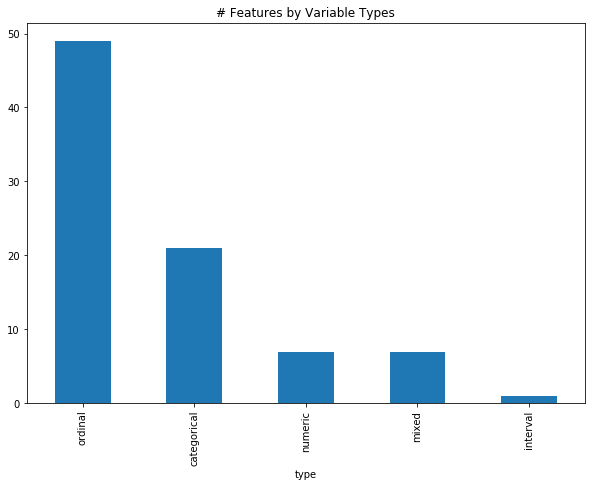

In [31]:
# How many features are there of each data type?
(feat_info.groupby('type').count()['attribute']
                        .sort_values(ascending = False).plot(kind = 'bar', figsize = (10, 7)))
plt.title('# Features by Variable Types')
plt.show()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), encode the values using multiple dummy variables (via [OneHotEncoder]

Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded

In [54]:
categoricals = list(feat_info[feat_info['type'] == 'categorical']['attribute'].values)
print('Categorical features unique values:')
_ = azdias[categoricals].apply(lambda x: print(x.name, ':', x.unique()))

Categorical features unique values:
AGER_TYP : [nan 2.0 3.0 1.0]
ANREDE_KZ : [1 2]
CJT_GESAMTTYP : [2.0 5.0 3.0 4.0 1.0 6.0 nan]
FINANZTYP : [4 1 6 5 2 3]
GFK_URLAUBERTYP : [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [2.0 5.0 1.0 nan 10.0 7.0 11.0 3.0 8.0 4.0 6.0 9.0]
LP_FAMILIE_GROB : [2.0 3.0 1.0 nan 5.0 4.0]
LP_STATUS_FEIN : [1.0 2.0 3.0 9.0 4.0 10.0 5.0 8.0 6.0 7.0 nan]
LP_STATUS_GROB : [1.0 2.0 4.0 5.0 3.0 nan]
NATIONALITAET_KZ : [nan 1.0 3.0 2.0]
SHOPPER_TYP : [nan 3.0 2.0 1.0 0.0]
SOHO_KZ : [nan 1.0 0.0]
TITEL_KZ : [nan 4.0 1.0 3.0 5.0 2.0]
VERS_TYP : [nan 2.0 1.0]
ZABEOTYP : [3 5 4 1 6 2]
KK_KUNDENTYP : [nan 1.0 3.0 6.0 4.0 2.0 5.0]
GEBAEUDETYP : [nan 8.0 1.0 3.0 2.0 6.0 4.0 5.0]
OST_WEST_KZ : [nan 'W' 'O']
CAMEO_DEUG_2015 : [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1']
CAMEO_DEU_2015 : [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B'

The categorical variables that are encoded by non-numerical features are **OST_WEST_KZ ** and **CAMEO_DEU_2015 **

#### Discussion 1.2.1: Re-Encode Categorical Features


All of the categorical variables (except for **GREEN_AVANTGARDE**, which is already encoded as [0,1] binary) are encoded by one-hot encoding. Since categorical features does not have a specific ordering, the relative numerical values does not have any meaning, therefore the ordering effect needs to be removed by encoding these features as one-hot columns

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [53]:
mixed = list(feat_info[feat_info['type'] == 'mixed']['attribute'].values)
_ = azdias[mixed].apply(lambda x: print(x.name, ':', x.unique()))

LP_LEBENSPHASE_FEIN : [15.0 21.0 3.0 nan 32.0 8.0 2.0 5.0 10.0 4.0 6.0 23.0 12.0 20.0 1.0 11.0
 25.0 13.0 7.0 18.0 31.0 19.0 38.0 35.0 30.0 22.0 14.0 33.0 29.0 24.0 28.0
 37.0 26.0 39.0 27.0 36.0 9.0 34.0 40.0 16.0 17.0]
LP_LEBENSPHASE_GROB : [4.0 6.0 1.0 nan 10.0 2.0 3.0 5.0 7.0 12.0 11.0 9.0 8.0]
PRAEGENDE_JUGENDJAHRE : [nan 14.0 15.0 8.0 3.0 10.0 11.0 5.0 9.0 6.0 4.0 2.0 1.0 12.0 13.0 7.0]
WOHNLAGE : [nan 4.0 2.0 7.0 3.0 5.0 1.0 8.0 0.0]
CAMEO_INTL_2015 : [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']
KBA05_BAUMAX : [nan 5.0 1.0 2.0 3.0 4.0]
PLZ8_BAUMAX : [nan 1.0 2.0 4.0 5.0 3.0]


In [99]:
# Re-encode categorical variable(s) to be kept in the analysis.
dropped = set.intersection(set.union(set(attributes_outlier_list),set(columns_to_drop)), set(categoricals), set(mixed))
one_hot = set(attributes_outlier_list) - dropped
cate_encode = list(set.union(set(categoricals),set(mixed)) 
                 - dropped - set(['GREEN_AVANTGARDE', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']))
azdias_dummies = pd.get_dummies(azdias, columns=cate_encode, dummy_na = True)

**PRAEGENDE_JUGENDJAHRE**

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown
- 0: unknown
- 1: 40s - war years (Mainstream, E+W)
- 2: 40s - reconstruction years (Avantgarde, E+W)
- 3: 50s - economic miracle (Mainstream, E+W)
- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- 5: 60s - economic miracle (Mainstream, E+W)
- 6: 60s - generation 68 / student protestors (Avantgarde, W)
- 7: 60s - opponents to the building of the Wall (Avantgarde, E)
- 8: 70s - family orientation (Mainstream, E+W)
- 9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [35]:
full_map = pd.DataFrame({-1: [np.nan, np.nan],
                          0: [np.nan, np.nan],
                          1: [40, 1],
                          2: [40, 0],
                          3: [50, 1],
                          4: [50, 0],
                          5: [60, 1],
                          6: [60, 0],
                          7: [60, 0],
                          8: [70, 1],
                          9: [70, 0],
                          10: [80, 1],
                          11: [80, 0],
                          12: [80, 1],
                          13: [80, 0],
                          14: [90, 1],
                          15: [90, 0],
                        np.nan: [np.nan, np.nan]}).T

# Create column that encodes decades
decades_map = full_map[0].to_dict()
azdias['DECADES'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decades_map)

# Create column that encodes movements 
movements_map = full_map[1].to_dict()
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movements_map)

**CAMEO_INTL_2015**

German CAMEO: Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown



In [37]:
azdias['WEALTH'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])//10
azdias['LIFE_STAGE'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])%10

#### Discussion 1.2.2: Engineer Mixed-Type Features


The two columns that contains more than 1 dimensions of data, **PRAEGENDE_JUGENDJAHRE** and **CAMEO_INTL_2015** are engineered in ways that could separate dimensions. The rest of the mixed values columns only contains 1 dimension, therefore are left as the same as their original states

#### Step 1.2.3: Complete Feature Selection

Now datagrame contains only the columns that you want to keep. 
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.


In [38]:
outlier_columns = list(set(attributes_outlier_list) - one_hot)
azdias.drop((['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'] + outlier_columns), axis = 1, inplace = True)

### Step 1.3: Create a Cleaning Function

Functions for main feature selection, encoding, and re-engineering steps that performed above. Then, when looking at the customer data in Step 3, we could just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df, outlier_columns):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    feat_info['missing_or_unknown'].replace({'[-1,X]': '[-1,"X"]',
                                         '[-1,XX]': '[-1,"XX"]',
                                          '[XX]': '["XX"]'}, inplace = True)
    encodings = feat_info.set_index('attribute')['missing_or_unknown'].to_dict()
    encodings = {key: {k: np.nan for k in literal_eval(value)} for key, value in encodings.items()}
    for columns, mapping in encodings.items():
        df[columns].replace(mapping, inplace = True)
    
    # Drop the outlier columns

    df.drop(outlier_columns, axis=1, inplace=True)
    
    # Remove highly correlated numerical features
    df_num = df.select_dtypes(include = ['float64', 'int64'])
    
    columns_correlated = correlated_columns_to_drop(df_num, 0.95)
    df.drop(columns_correlated, axis=1, inplace=True)
 
    # catgorical variables
    categoricals = list(feat_info[feat_info['type'] == 'categorical']['attribute'].values)
    mixed = list(feat_info[feat_info['type'] == 'categorical']['attribute'].values)
    dropped = set.intersection(set.union(set(attributes_outlier_list),set(columns_to_drop)), set(categoricals), set(mixed))
    one_hot = set(outlier_columns) - dropped
    cate_encode = list(set.union(set(categoricals),set(mixed)) 
                 - dropped - set(['GREEN_AVANTGARDE', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']))
    df = pd.get_dummies(df, columns=cate_encode, dummy_na = True)
    
    # mixed variables - PRAEGENDE_JUGENDJAHRE
    full_map = pd.DataFrame({-1: [np.nan, np.nan],
                              0: [np.nan, np.nan],
                              1: [40, 1],
                              2: [40, 0],
                              3: [50, 1],
                              4: [50, 0],
                              5: [60, 1],
                              6: [60, 0],
                              7: [60, 0],
                              8: [70, 1],
                              9: [70, 0],
                              10: [80, 1],
                              11: [80, 0],
                              12: [80, 1],
                              13: [80, 0],
                              14: [90, 1],
                              15: [90, 0],
                              np.nan: [np.nan, np.nan]}).T

    # Create column that encodes decades
    decades_map = full_map[0].to_dict()
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].map(decades_map)

    # Create column that encodes movements 
    movements_map = full_map[1].to_dict()
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].map(movements_map)
    
    # mixed variables - CAMEO_INTL_2015
    df['WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015'])//10
    df['LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015'])%10
    
    # drop extra columns
    outlier_columns = list(set(outlier_columns) - one_hot)
    df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'] + outlier_columns, axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return df

In [63]:
# Load in the general demographics data.
azdias = pd.read_csv('zadias.csv', delimiter=',')

In [23]:
azdias_nan.head()

,sum,percent
ALTER_KIND4,890016,99.86
TITEL_KZ,889061,99.76
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90


Run azdias through clean data and make sure the columns are the same

In [ ]:
outlier_columns = azdias_nan[azdias_nan['percent'] >= 0.3].index.to_list()
azdias_clean = clean_data(azdias, outlier_columns)
feature_names = list(azdias_clean.columns)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling


- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler, make sure that the DataFrame has no missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. 
- For the actual scaling function, I used [StandardScaler], scaling each feature to mean 0 and standard deviation 1.


In [60]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,ZABEOTYP_nan,ANREDE_KZ_1.0,ANREDE_KZ_2.0,ANREDE_KZ_nan,SOHO_KZ_0.0,SOHO_KZ_1.0,SOHO_KZ_nan,DECADES,WEALTH,LIFE_STAGE
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,1,NaN,NaN,NaN
1,910220,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,0,0,1,0,0,1,0,90.0,5.0,1.0
2,910225,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,0,0,1,0,1,0,0,90.0,2.0,4.0
3,910226,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0,0,1,0,1,0,0,70.0,1.0,2.0
4,910241,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,0,1,0,0,1,0,0,70.0,4.0,3.0


Missing data impute

In [ ]:
imputer = SimpleImputer()
imputer_model = imputer.fit(azdias)
azdias_impute = pd.DataFrame(imputer_model.transform(azdias), columns = feature_names)

Apply a standard scalar

In [ ]:
scalar = StandardScaler()
scalar_model = scalar.fit(azdias_impute)
azdias_scaled = pd.DataFrame(scalar_model.transform(azdias_impute), columns = feature_names)

### Discussion 2.1: Apply Feature Scaling


The missing data are imputed first, then the data is scaled. Since the rows that have large number of missing data are dropped before, imputing missing values will not have a large impact on the overall distribution

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

Apply PCA to the data.

In [29]:
pca = PCA()
pca_model= pca.fit(azdias_scaled)
azdias_pca = pca_model.transform(azdias_scaled)

Plot % variance explained

In [30]:
def variance_plot(pca):
    '''
    Creates a variance plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
    
    OUTPUT: number of components suggested
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind[:150], vals[:150])
    ax.plot(ind[:150], cumvals[:150])
    try:
        for i in np.arange(0, 150, 10):
            ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i] , cumvals[i] + 0.02), 
                        va="bottom", ha="center", fontsize=12)

        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=2, length=12)
        ax.set_xlim([-1, 150])
        ax.set_xlabel("Principal Component")
        ax.set_ylabel("Variance Explained (%)")
        plt.title('Explained Variance Per Principal Component')
    except:
        pass
    
    fit_components = np.argmax(cumvals > 0.85)
    return fit_components

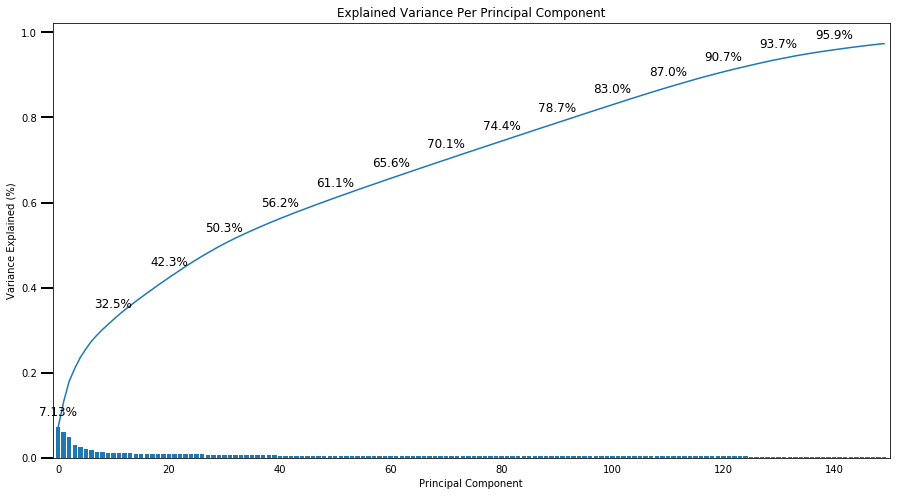

In [31]:
fit_components = variance_plot(pca)

Find the number of components that will explain at least 85% of the total variance, then reapply PCA

In [32]:
pca = PCA(fit_components)
pca_model= pca.fit(azdias_scaled)
azdias_pca = pca_model.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction



According to the scree plot above, I selected the number of components that will represent at least 95% of the total vairances, which gives the number of components to be 120

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [33]:
def getComponentLinkage(pca, component_number, feature_names):
    """Prints the sorted relevancy of each feature given the component
       
       INPUT: pca object, the component number, feature names
    """
    component_linkage = pd.DataFrame(pca.components_, columns = feature_names)
    relevancy = pd.DataFrame(component_linkage.iloc[component_number + 1,:]
                             .transpose().sort_values(ascending = False))
    relevancy.columns = ['weights']
    
    return relevancy.head(5), relevancy.tail(5).sort_values('weights')

In [34]:
def visualizeRelevancy(head_df, tail_df, PC_number):
    """Plot the top and bottom weights of PCs  
       
       INPUT: head, tail dfs
    """
    
    # create subplots
    ind = np.arange(len(head_df))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (16, 5))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    ax1.set_title('Highest Positive Relevancy')
    ax2.set_title('Highest Negative Relevancy')
    sns.barplot(x = head_df.index, y = head_df['weights'],  ax = ax1)
    sns.barplot(x = tail_df.index, y = tail_df['weights'], ax = ax2, data = tail_df)
    
    for i in range(len(head_df)):
        ax1.annotate(r"%s%%" % ((str(head_df['weights'][i]*100)[:4])), (ind[i] , -0.06), 
                    va="bottom", ha="center", fontsize=12)
        ax2.annotate(r"%s%%" % ((str(tail_df['weights'][i]*100)[:5])), (ind[i] , 0.02), 
                    va="bottom", ha="center", fontsize=12)
    plt.ylabel('Weights')
    plt.suptitle('PC' + str(PC_number))

First component relevancy

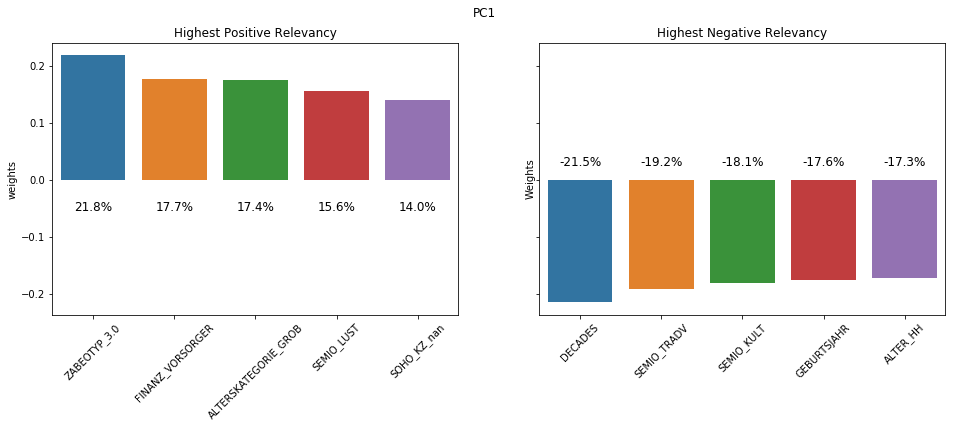

In [35]:
c1_head, c1_tail = getComponentLinkage(pca_model, 1, feature_names)
visualizeRelevancy(c1_head, c1_tail, 1)

Second component relevancy

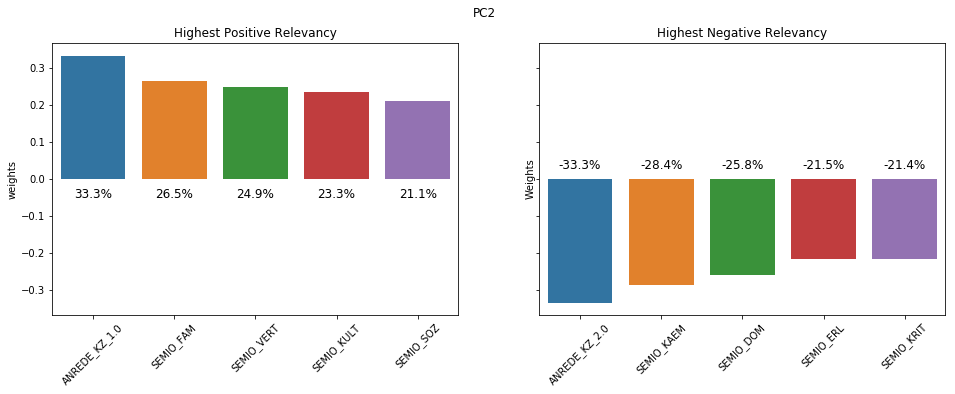

In [36]:
c2_head, c2_tail = getComponentLinkage(pca, 2, feature_names)
visualizeRelevancy(c2_head, c2_tail, 2)

Third component relevancy

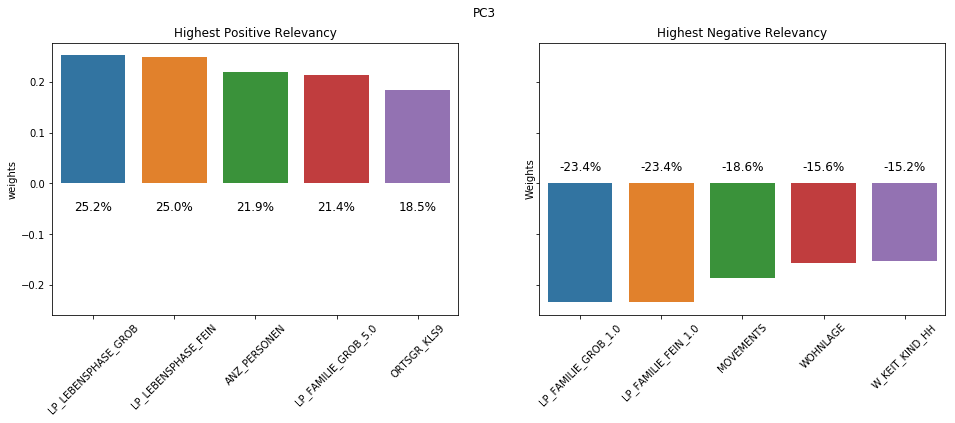

In [37]:
c3_head, c3_tail = getComponentLinkage(pca, 3, feature_names)
visualizeRelevancy(c3_head, c3_tail, 3)

### Discussion 2.3: Interpret Principal Components


**First Component**

The first component is mix a person's personality topology, financial topology and age factors. Most of the weights are relatively uniform. Esitmated age has opposite weights with person's birth decades, which aligns with our intuition

Top positively correlated features with PC1,

* Energy comsuption topology (**ZABEOTYP - Fairly Supplied**) ~ 21.8 %
* Finacial topology -be prepared (**FINANZ_VORSORGER**) ~17.7 %
* Estimated age (**ALTERSKATEGORIE_GROB**) ~ 17.4 %

Top negatively correlated features with PC1,

* Person's birth decades (**DECADES**)  ~ -21.5 % 
* Traditional minded (**SEMIO_TRADEV**)  ~ -19.2 %
* Cultural minded (**SEMIO_KULT**) ~ -18.1 %



**Second Component**

The second component is mostly related to genders of customers and perosnality traits. The male and female represents the largest positive and negative weights.

Top positively correlated features with PC2,


* Gender - Male (**ANREDE_KZ_1**) ~33.3 %
* Family minded (**SEMIO_FAM**) ~ 17.4 %
* Dreamful personalities (**SEMIO_VERT**) ~ 17.7 %

the negatively correlated features with PC2,

* Gender - Male (**ANREDE_KZ_2**) ~ - 33.3%
* Combative personalities (**SEMIO_KAEM**) ~ - 28.4%
* Dominated personalities (**SEMIO_DOM**) ~ - 25.8%

Opposite personalities traits are captured in PC2, as more peaceful personalities have large positive weights and more aggressive personalities have large negative weights. Personalities has significant effects on personal behaviors, the weights in second component valided the point

**Third Component**

The third components is describing the person's life stages, family traits and income levels. 

Top positively correlated feattures with PC3,

* Life stages - rough scale (**LP_LEBENSPHASE_GROB**) ~ 25.2 %
* Life stages - fine scale (**LP_LEBENSPHASE_FEIN**) ~ 25.0 %
* Number of adults in house (**ANZ_PERSONEN**) ~ 21.9 %

Top negatively correlated features with PC3,

* Family type - fine scale (**LP_FAMILIE_FEIN**) ~ - 23.4 %
* Family type - rough scale (**LP_FAMILIE_GROB**) ~ - 23.4 %
* Movements (**MOVEMENTS**) ~ - 18.6 %

Different types of families, life stages and the immigrating activities will also affects people's behaviors. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [38]:
cluster_nums =  [1, 4, 8] + list(np.arange(10, 36, 5)) 
avg_d = []
for i in cluster_nums:
    # run k-means clustering on the data
    kmeans = KMeans(i)
    kmeans.fit(azdias_pca)
    # compute the average within-cluster distances
    avg_d.append(-kmeans.score(azdias_pca))

Plot the scores and find the right number of clusters using the elbow method

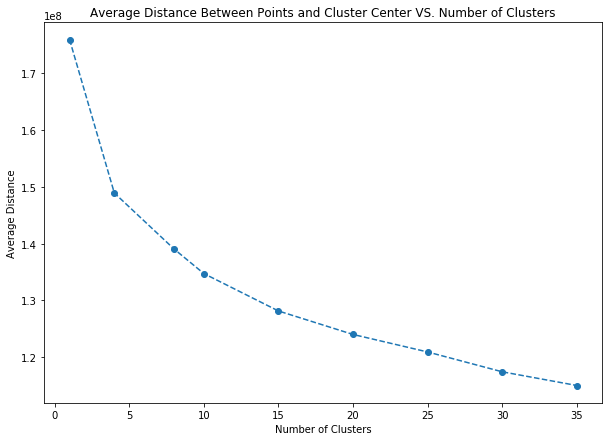

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(cluster_nums, avg_d,  linestyle='--', 
         marker='o')

plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Average Distance Between Points and Cluster Center VS. Number of Clusters')
plt.show()

From the plot above, though there is no obvious elbow in the dataset, the number of clusters could be chosen as 25. The below selection also shows 25 is the number of clusters that should be implemented

In [40]:
d_change = np.diff(avg_d)
n_clusters = cluster_nums[np.argmin(abs(d_change)) - 1]

Refit the K means cluster

In [41]:
kmeans = KMeans(n_clusters)
kmeans_best = kmeans.fit(azdias_pca)
azdias_impute['clusters'] = kmeans_best.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population


Using the elbow method, the average distance does not decrease a lot after number of clusters reaches 20. The appropriate number of clusters is therefore chosen to be 20

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [42]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, 
obtaining cluster predictions for the customer demographics data.

In [43]:
customers = clean_data(customers, outlier_columns)

Fit PCA using the same sklearn object used to fit the demographics data

In [44]:
def transform_data(df, feature_names, imputer, scalar, pca):
    """Impute, Scale and find PCA of the input data"""
    if set(feature_names) != set(df.columns):
        missing_cols = list(set(feature_names) - set(df.columns))
        df = pd.concat([df, pd.DataFrame(columns = missing_cols)])
        df = df.reindex(columns = feature_names)
        df[missing_cols] = 0
    df_imputed = imputer.transform(df)
    df_scaled = scalar.transform(df_imputed)
    df_pca = pca.transform(df_scaled)
    
    return df_pca, pd.DataFrame(df_imputed, columns=feature_names)

In [45]:
customers_pca, customers_impute = transform_data(customers, feature_names, imputer_model, scalar_model, pca_model)

Fit the clustering object on customer level data

In [46]:
customers_impute['clusters'] = kmeans_best.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Group count on all the data in different clusters

In [47]:
# general demographics
azdias_clusters_cnt = pd.DataFrame(azdias_impute.groupby(['clusters'], as_index= False).count().iloc[:, :2])
azdias_clusters_cnt.iloc[:, 1] = azdias_clusters_cnt.iloc[:, 1]/sum(azdias_clusters_cnt.iloc[:, 1]) *100
azdias_clusters_cnt['dataset'] = 'General'

# customers demographics
customers_clusters_cnt = pd.DataFrame(customers_impute.groupby(['clusters'], as_index= False).count().iloc[:, :2])
customers_clusters_cnt.iloc[:, 1] = customers_clusters_cnt.iloc[:, 1]/sum(customers_clusters_cnt.iloc[:, 1]) *100
customers_clusters_cnt['dataset'] = 'Customers'

Concatenate clusters together

In [48]:
clusters_cnt = pd.concat([azdias_clusters_cnt, customers_clusters_cnt])
clusters_cnt.columns = ['clusters','percentage %','dataset'] 

Visualize the % of datapoints in each cluster

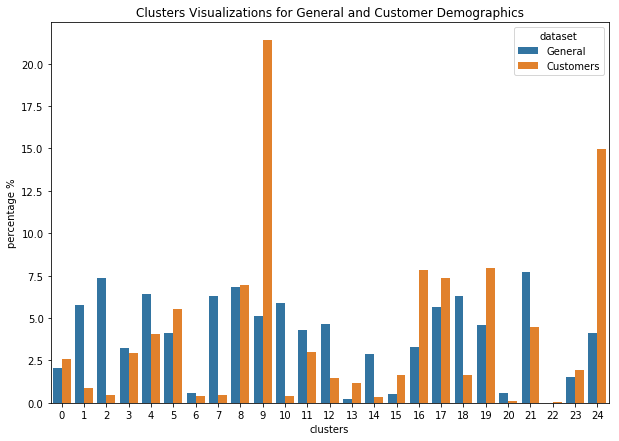

In [49]:
plt.figure(figsize=(10, 7))
sns.barplot(data=clusters_cnt, x = 'clusters', y ='percentage %',  hue = 'dataset')
plt.title('Clusters Visualizations for General and Customer Demographics')
plt.show()

Select over and under represented clusters

In [50]:
# pivot cluster tables
clusters_pivot = clusters_cnt.pivot(index = 'clusters',  columns= 'dataset', values= 'percentage %')
clusters_pivot['difference %'] = clusters_pivot['Customers'] - clusters_pivot['General']

### Discussion 3.3: Compare Customer Data to Demographics Data

In [51]:
def getCentroids(centroids_nums, feature_names, customers):
    """Get the features given the cluster centroid numbers"""
    centroids = customers[customers['clusters'].isin(centroids_nums)]
    return pd.DataFrame(centroids.iloc[:, :-1].mean()).T

In [52]:
def getMeanRest(centroids_nums, customers):
    """Get the mean of the rest of the data"""
    rest_customers = customers[~customers['clusters'].isin(centroids_nums)]
    return pd.DataFrame(rest_customers.iloc[:, :-1].mean()).T

**Overrepresented population**

Select the top 2 over represented clusters, 18 and 20

In [53]:
overrepresented  = list(clusters_pivot['difference %'].sort_values(ascending = False).head(2).index)

In [54]:
clusters_diff = pd.concat([getCentroids([overrepresented[0]], feature_names,customers_impute ), 
                           getCentroids([overrepresented[1]], feature_names, customers_impute), 
                           getMeanRest(overrepresented, customers_impute)])
clusters_diff.set_index(pd.Series(overrepresented + ['rest']), inplace = True)

Find representative features

In [55]:
average_diff = (abs(clusters_diff.loc[overrepresented[0]] - clusters_diff.loc['rest']) 
                + abs(clusters_diff.loc[overrepresented[1]] - clusters_diff.loc['rest']))/2
top5_diff = list(average_diff.sort_values(ascending = False).head(5).index)

Visualize cluster the top 5 different features

In [56]:
clusters_diff[top5_diff]

,KBA13_ANZAHL_PKW,DECADES,GEBURTSJAHR,LP_LEBENSPHASE_FEIN,ANZ_HAUSHALTE_AKTIV
9,619.698207,73.328046,1967.102689,16.332161,8.354924
24,694.675669,55.834402,1953.619264,28.864037,1.553170
rest,656.748831,60.466167,1956.264147,22.644504,6.186470


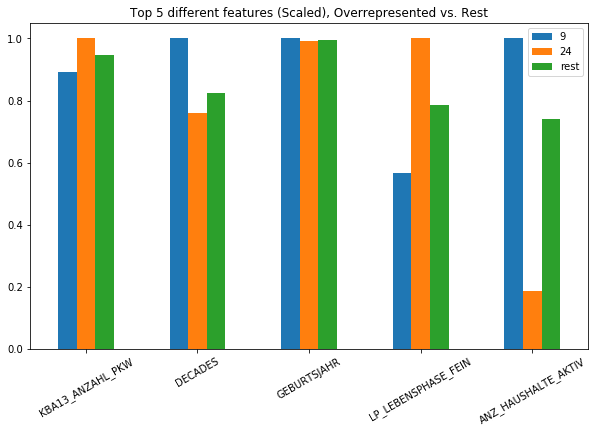

In [57]:
clusters_diff[top5_diff].apply(lambda x: x/ max(x)).T.plot(kind = 'bar', 
                                                    figsize = (10, 6),
                                                    title = 'Top 5 different features (Scaled), Overrepresented vs. Rest')
plt.xticks(rotation = 30)
plt.show()

Cluster 9, the most over represented cluster, is showing signnificant differences in these 5 features with the rest of populations. In some features dimensions, the second most overrepresented cluster 24, also have significant differences with the rest of the populations in a different way. 

In particular, cluster 9 has the following characteristics besides the rest

* Lower number of cars in region (**KBA13_ANZAHL_PKW**)   --- Lower income
* Higher value in birth decade (**DECADES**), lower birth year (1967) (**GEBURTSJAHR**)  --- Mid aged population
* Life stage (**LP_LEBENSPHASE_FEIN**) close to 16 -- Average earners couples

cluster 24 has the following characteristics besides the rest 

* Higher number of cars in region (**KBA13_ANZAHL_PKW**)   --- Higher income
* Lower value in birth decade (**DECADES**), lower birth year (1953) (**GEBURTSJAHR**)  --- Elderly population
* Life stage (**LP_LEBENSPHASE_FEIN**) close to 28 -- Top earners

Arvato's primary customers seems to be individuals who are middle-aged to elderly, has a family, average to top earners.

**Underrepresented Clusters**

Select the top 2 under represented clusters, 15 and 16

In [58]:
underrepresented = list(clusters_pivot['difference %'].sort_values(ascending = False).dropna().tail(2).index)

In [59]:
clusters_diff = pd.concat([getCentroids([underrepresented[0]], feature_names ,customers_impute), 
                           getCentroids([underrepresented[1]], feature_names,customers_impute), 
                           getMeanRest(underrepresented, customers_impute)])
clusters_diff.set_index(pd.Series(underrepresented + ['rest']), inplace = True)

In [60]:
average_diff = (abs(clusters_diff.loc[underrepresented[0]] - clusters_diff.loc['rest']) 
                + abs(clusters_diff.loc[underrepresented[1]] - clusters_diff.loc['rest']))/2
top5_diff = list(average_diff.sort_values(ascending=False).head(5).index)

In [61]:
clusters_diff[top5_diff]

,KBA13_ANZAHL_PKW,DECADES,GEBURTSJAHR,LP_LEBENSPHASE_FEIN,ANZ_HAUSHALTE_AKTIV
7,721.796890,83.814499,1974.850683,13.001715,4.692734
2,487.111996,84.919094,1975.162247,12.537518,13.771688
rest,655.004609,62.308560,1958.020757,22.319477,5.923502


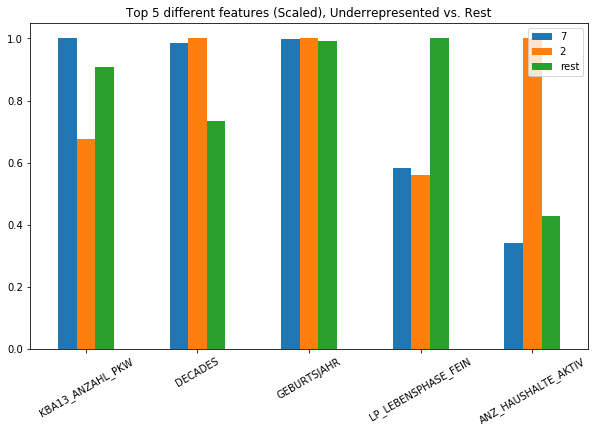

In [63]:
clusters_diff[top5_diff].apply(lambda x: x/ max(x)).T.plot(kind = 'bar', 
                                                    figsize = (10, 6),
                                                    title = 'Top 5 different features (Scaled), Underrepresented vs. Rest')
plt.xticks(rotation = 30)
plt.show()

Cluster 7 and 2 are significantly under represented. The also have significant differences with the rest of the population

In particular, cluster 9 has the following characteristics

* Significantly higher number of cars in region (**KBA13_ANZAHL_PKW**), even more than cluster 24   --- Significantly higher income
* Significantly Higher value in birth decade (**DECADES**), higher birth year (1973) (**GEBURTSJAHR**) (higher than cluster 7) --- Younger middle-aged population
* Life stage (**LP_LEBENSPHASE_FEIN**) number close to 13 ---- Single top earners at higher age

Cluster 2 has the following characteristics

* Significant lower number of cars in region (**KBA13_ANZAHL_PKW**), even less than cluster 9   --- Significantly lower income
* Significantly Higher value in birth decade (**DECADES**), higher birth year (1975) (**GEBURTSJAHR**) (higher than cluster 7) --- Younger middle-aged populatio
* Life stage (**LP_LEBENSPHASE_FEIN**) number close to 12 ---- single homeowners at retirement age

Two types of individuals are not significantly represented in Arvato's customer base. Those who do not have a family, on the more extreme side of income generation abilities (either extremely rich or pretty poor), are not very interested in Arvato's products. These people are on the younger spectrum of middle aged group. 